In [7]:
import sys
sys.path.insert(1, '../')

from river import stream,tree,metrics
from encoding import prefix_bin
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score
from tqdm import tqdm
import pickle as pkl
import matplotlib.pyplot as plt
import os,json
import datetime
from collections import deque, Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

import pandas as pd

import warnings

warnings.filterwarnings("ignore")
import xgboost as xgb

import datetime, time
import utils
import sliding_window
import psutil
import gzip
import copy
from collections import Counter

In [8]:
def update_test_cases(new_case, test_cases):
    test_cases.append(new_case)
    if len(test_cases) > test_size:
        test_cases.popleft()

In [11]:
for dataset_label in ['bpic2011_1','bpic2011_3','bpic2011_4','bpic2015_1','bpic2015_2','bpic2015_3','bpic2015_4','bpic2015_5',
                      'Production_Data','sepsis_cases_1','sepsis_cases_2','sepsis_cases_3','traffic_fines_1','hospital_billing_1',
                      'hospital_billing_2']:
# for dataset_label in ['bpic2012_1', 'bpic2012_2', 'bpic2012_3','bpic2017_1','bpic2017_2','bpic2017_3','IRO5K' ,'OIR5K']:

    # Experiment settings
    print(dataset_label)

    # Experiment settings
    './DATA/logs/synthetic_log_bc1.csv'

    # Invoke parameters for dataset
    window_size = 200
    test_size = 30
    gp=200
    training_rebalance = True
    retraining_condition = 'variant'
    with open('../dataset_parameters.json','r') as json_file:
        parameters = json.load(json_file)[dataset_label]
        print(parameters)
        key_pair = parameters['key_pair']
        catatars = parameters['categorical_attrs']
        prefix_range = parameters['prefix']
        
    for maximum_prefix in prefix_range:
        print(maximum_prefix)
        retraining_check = True

        train_window_dict = {}
        test_window_dict = {}
        dataset_loc = '../DATA/logs/'+ dataset_label +'.csv'
        try:
            os.makedirs('../result/%s'%(dataset_label))
        except:
            pass
        
        # Set streaming classifier
        classifier = 'hatc'
        if classifier == 'htc':
            streaming_classifier = tree.HoeffdingTreeClassifier(grace_period=30, split_criterion='info_gain')
        elif classifier =='hatc':
            streaming_classifier = tree.HoeffdingAdaptiveTreeClassifier(grace_period=5, delta = 0.8, split_criterion='info_gain', seed=500)
        elif classifier == 'efdt':
            streaming_classifier = tree.ExtremelyFastDecisionTreeClassifier(grace_period=30, split_criterion='info_gain')

        dataset = stream.iter_csv(
                dataset_loc
                )

        totallength = len(list(dataset))

        dataset = stream.iter_csv(
                dataset_loc,
                # drop=['Complete Timestamp'],
                target='outcome'
                )
        enctype = 'Index-base'

        streaming_db ={}
        training_models ={}
        training_windows = sliding_window.training_window(window_size,test_size)

        test_cases = deque()
        feature_matrix ={}

        save_model = {}
        casecount = 0
        rowcounter = 0
        finished_db ={}
        running_case = 0
        window_acc_dict = {}
        prediction_result = dict()
        for i in range(1, maximum_prefix+1): prediction_result[i] = {}
        finished_caseid = set()
        usedingrace = set()


        '''
        Before test and training streaming event predictive monitoring, grace period is preceded to initialize model by prefix length
        and obtain feature matrix to transform future events
        '''
        for x,y in dataset:
    #         display_progress(rowcounter, totallength)
            rowcounter +=1
            # Event stream change dictionary keys
            x = utils.dictkey_chg(x, key_pair)

#             if dataset_label !='bpic15':
#                 x['ts'] = x['ts'][:-4]

            x['outcome'] =y 
            # Initialize case by prefix length        
            caseid = x['caseid']
            outcome = x['outcome']
        #     progress = x['progress']

            x.pop('caseid')
            x.pop('outcome')

        #     x.pop('progress')

            case_bin = prefix_bin(caseid, x)
            case_bin.set_enctype(enctype)

            if caseid not in list(streaming_db.keys()):
                case_bin.set_prefix_length(1)    
                streaming_db[caseid] = []
            elif caseid in finished_caseid:
                pass
            else:
                case_bin.set_prefix_length(len(streaming_db[caseid])+1)
                case_bin.set_prev_enc(streaming_db[caseid][-1])

            # Encode event and cases and add to DB
            case_bin.update_truelabel(outcome)   
            case_bin.update_encoded(catattrs=catatars,enctype=enctype)
            ts = case_bin.event['ts']
            streaming_db[caseid].append(case_bin)
            # Detect label appeared case 
            if outcome != '' and caseid not in finished_caseid:
                usedingrace.add(caseid)
                for i in streaming_db[caseid]:
                    i.update_truelabel(outcome)
                finished_caseid.add(caseid)
                # Adding newly finished case to training set.    
                casecount +=1
                # Grace period to collect feature matrix
                if casecount < gp:
                    case_length = len(streaming_db[caseid])
                    if case_length >= maximum_prefix:
                        if 'prefix_%s'%(maximum_prefix) not in list(feature_matrix.keys()):
                            feature_matrix['prefix_%s'%(maximum_prefix)]=set()
                            training_models['prefix_%s'%(maximum_prefix)] = [streaming_classifier,
                                                                       0]
                        feature_list = list(streaming_db[caseid][maximum_prefix-1].encoded.keys())
                        for x in feature_list: feature_matrix['prefix_%s'%(maximum_prefix)].add(x) 
                else:
                    break

        casecount_=0
        if casecount not in train_window_dict.keys(): train_window_dict[casecount] = []
        if casecount not in test_window_dict.keys(): test_window_dict[casecount] = []

        for caseid in list(usedingrace):
            case_length = len(streaming_db[caseid])
            if case_length >= maximum_prefix:
                x = streaming_db[caseid][maximum_prefix-1]
                if x.prefix_length != 0:            
                    training_windows.update_window(x)
                update_test_cases(streaming_db[caseid], test_cases)

        prediction_result[maximum_prefix][casecount] = {}

        if training_rebalance == True:
            x_prefix_length = training_windows.container[0].prefix_length
            training_x = [utils.readjustment_training(i.encoded, feature_matrix['prefix_%s'%(maximum_prefix)]) for i in training_windows.container]
            training_y = [i.true_label for i in training_windows.container]
            training_x = pd.DataFrame.from_dict(training_x)

            n_labels = Counter(training_y)['True']

            if n_labels <=2:
                pass
            elif n_labels>2 and n_labels <=5:
                smote = SMOTE(k_neighbors=n_labels-1)
                training_x, training_y = smote.fit_resample(training_x, training_y)
            else:
                smote = SMOTE()
                training_x, training_y = smote.fit_resample(training_x, training_y)

            balanced_training_windows = []
            for i in range(len(training_x)):
                balanced_training_windows.append((training_x.iloc[i, :], training_y[i]))

            for pos, i in enumerate(balanced_training_windows):
                x, y = i[0], i[1]
                training_models['prefix_%s'%(x_prefix_length)][0].learn_one(x,y)
            training_models['prefix_%s'%(x_prefix_length)][1] =casecount
        else:

            for pos, i in enumerate(training_windows.container):
                x_prefix_length = i.prefix_length 
                i.encoded = utils.readjustment_training(i.encoded, feature_matrix['prefix_%s'%(maximum_prefix)])
                training_models['prefix_%s'%(x_prefix_length)][0].learn_one(i.encoded,i.true_label)
            training_models['prefix_%s'%(x_prefix_length)][1] =casecount
        train_window_dict[casecount].append(copy.deepcopy(training_windows.container))    
        y_truelist = []
        y_predlist = []
        for case in test_cases:
            if len(case) >= maximum_prefix:
                x = case[maximum_prefix-1]
                if x.prefix_length != 0:            
                    model = training_models['prefix_%s'%(x.prefix_length)][0]
                    y_pred = training_models['prefix_%s'%(x.prefix_length)][0].predict_proba_one(x.encoded)
                    y_truelist.append(x.true_label)
                    y_predlist.append(y_pred)
                    test_window_dict[casecount].append(x)
        prediction_result[maximum_prefix][casecount]['y_true'] = y_truelist
        prediction_result[maximum_prefix][casecount]['y_pred'] = y_predlist


        '''
        Streaming event label prediction start.
        - Test and training steps are executed when case finished/ event arrived with label
        '''
        for i in streaming_db.keys(): usedingrace.add(i)
        streaming_db ={}
        cdhappend ={}
        for i in range(1, maximum_prefix+1): cdhappend[i] = 0
        for x,y in dataset:
    #         display_progress(rowcounter, totallength)

            rowcounter +=1
            # Event stream change dictionary keys
            x = utils.dictkey_chg(x, key_pair)

#             if dataset_label !='bpic15':
#                 x['ts'] = x['ts'][:-4]

            # Check label possible
            # x = utils.set_label(x)
            x['outcome'] =y 
            # Initialize case by prefix length
            caseid = x['caseid']
            outcome = x['outcome']
            x.pop('caseid')
            x.pop('outcome')

            if caseid not in usedingrace:
                case_bin = prefix_bin(caseid, x)
                case_bin.set_enctype(enctype)

                if caseid not in list(streaming_db.keys()):
                    case_bin.set_prefix_length(1)    
                    streaming_db[caseid] = []
                    running_case +=1
                elif caseid in finished_caseid:
                    pass
                else:
                    case_bin.set_prefix_length(len(streaming_db[caseid])+1)
                    case_bin.set_prev_enc(streaming_db[caseid][-1])

                # Encode event and cases and add to DB
                case_bin.update_truelabel(outcome)   
                case_bin.update_encoded(catattrs=catatars,enctype=enctype)
                ts = case_bin.event['ts']

                if case_bin.prefix_length == maximum_prefix:
                    case_bin.encoded = utils.readjustment_training(case_bin.encoded, feature_matrix['prefix_%s'%(case_bin.prefix_length)])
                streaming_db[caseid].append(case_bin)

                # Detect label appeared case 
                if outcome != '' and caseid not in finished_caseid:
                    finished_caseid.add(caseid)

                    # Adding newly finished case to training set.
                    casecount +=1    

                    # Modify encoded attributes of cases with feature matrix
                    case_length = len(streaming_db[caseid])
                    if case_length >= maximum_prefix:

                        update_test_cases(streaming_db[caseid], test_cases)
                        streaming_db[caseid][maximum_prefix-1].update_truelabel(outcome)
                        x = streaming_db[caseid][maximum_prefix-1].encoded
                        prefix_length =streaming_db[caseid][maximum_prefix-1].prefix_length

                        y_pred = training_models['prefix_%s'%(prefix_length)][0].predict_one(x)
                        model_update_count = training_models['prefix_%s'%(prefix_length)][1]

                        save_model['%s_%s'%(prefix_length, model_update_count)] = training_models['prefix_%s'%(streaming_db[caseid][maximum_prefix-1].prefix_length)][0]

                    y_truelist = []
                    y_predlist = []

                    for case in test_cases:
                        if len(case) >= maximum_prefix:
                            x = case[maximum_prefix-1]
                            if x.prefix_length != 0:
                                length = x.prefix_length
                                y_pred = training_models['prefix_%s'%(x.prefix_length)][0].predict_proba_one(x.encoded)
                                y_truelist.append(x.true_label)
                                y_predlist.append(y_pred)

                                if casecount not in test_window_dict.keys():
                                    test_window_dict[casecount] = []
                                test_window_dict[casecount].append(x)
                    prediction_result[maximum_prefix][casecount] = {}
                    prediction_result[maximum_prefix][casecount]['y_true'] = y_truelist
                    prediction_result[maximum_prefix][casecount]['y_pred'] = y_predlist
                    if 'b1' not in caseid and cdhappend[maximum_prefix] == 0:
                        cdhappend[maximum_prefix] = model_update_count

        try:
            os.makedirs('../result/%s/%s/Finished cases/Train once'%(dataset_label, classifier))
        except:
            pass    
            
        with gzip.open('../result/%s/%s/Finished cases/Train once/prefix_%s training window.pkl'%(dataset_label, classifier, maximum_prefix), 'wb') as f:
            pkl.dump(train_window_dict, f)
        with gzip.open('../result/%s/%s/Finished cases/Train once/prefix_%s test window.pkl'%(dataset_label, classifier, maximum_prefix), 'wb') as f:
            pkl.dump(test_window_dict, f)
        with gzip.open('../result/%s/%s/Finished cases/Train once/prefix_%s update.pkl'%(dataset_label, classifier, maximum_prefix), 'wb') as f:
            pkl.dump(prediction_result, f)
        with gzip.open('../result/%s/%s/Finished cases/Train once/prefix_%s model.pkl'%(dataset_label, classifier, maximum_prefix), 'wb') as f:
            pkl.dump(save_model, f)    

bpic2011_1
{'key_pair': {'Case ID': 'caseid', 'Activity': 'activity', 'Resource': 'resource', 'Complete Timestamp': 'ts'}, 'categorical_attrs': ['activity', 'resource'], 'maximum_prefix': 40, 'prefix': [10, 19, 27]}
10
19
27
bpic2011_3
{'key_pair': {'Case ID': 'caseid', 'Activity': 'activity', 'Resource': 'resource', 'Complete Timestamp': 'ts'}, 'categorical_attrs': ['activity', 'resource'], 'maximum_prefix': 40, 'prefix': [9, 16, 24]}
9
16
24
bpic2011_4
{'key_pair': {'Case ID': 'caseid', 'Activity': 'activity', 'Resource': 'resource', 'Complete Timestamp': 'ts'}, 'categorical_attrs': ['activity', 'resource'], 'maximum_prefix': 40, 'prefix': [11, 21, 30]}
11
21
30
bpic2015_1
{'key_pair': {'Case ID': 'caseid', 'Activity': 'activity', 'Resource': 'resource', 'Complete Timestamp': 'ts'}, 'categorical_attrs': ['activity', 'resource'], 'maximum_prefix': 40, 'prefix': [11, 21, 30]}
11
21
30
bpic2015_2
{'key_pair': {'Case ID': 'caseid', 'Activity': 'activity', 'Resource': 'resource', 'Complet

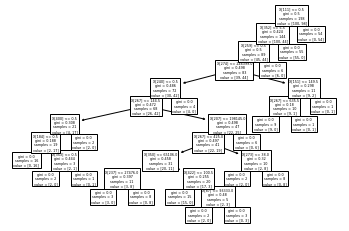

In [33]:
from sklearn import tree

from sklearn.tree import DecisionTreeClassifier


tree.plot_tree(cls)
plt.show()
